# DMD with Control without governing dynamics

In [27]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

sys.path.append(os.path.abspath(".."))
from src.dmd import DMDcRegressor
from src.plot import plot_results
from src.preprocessing import Hankel, PolynomialFeatures
from src.utils import normalize_string

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Set random seed for reproducibility
np.random.seed(42)

part = 1000

results_path = "results/.dmdc/"
if not os.path.exists(results_path):
    os.makedirs(results_path)

In [28]:
hm = 20
hl = 0
p = 0
q = 0

In [29]:
# Import train data
train_data = pd.read_pickle("data/train_sim.pkl")
# noise = np.zeros(train_data["X"].shape)
X: np.ndarray = (train_data["X"])[:-1]
U: np.ndarray = train_data["U"][:-1]
# We want Y_k to be X_{k+1}
Y: np.ndarray = (train_data["Y"])[1:]
n, m = X.shape
# Import test data
test_data = pd.read_pickle("data/test_sim.pkl")
X_t: np.ndarray = (test_data["X"])[:-1]
U_t: np.ndarray = test_data["U"][:-1]
Y_t: np.ndarray = (test_data["Y"])[1:]

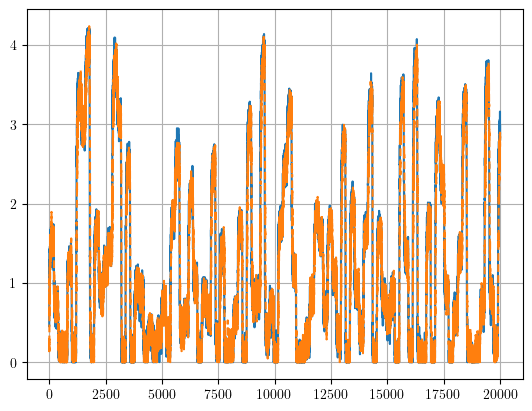

In [30]:
plt.plot(Y_t)

In [31]:
pipes = {
    "eDMDc w/o $\\sqrt{x}$": Pipeline([
        ("poly", PolynomialFeatures(3, interaction=False)),
        ("hankel", Hankel(hn=hm, step=1)),
        ("dmdc", DMDcRegressor(p=p, q=q)),
    ]),
    "eDMDc w $\\sqrt{x}$": Pipeline([
        (
            "poly",
            ColumnTransformer([
                ("sqrt", FunctionTransformer(np.sqrt), [0]),
                ("poly", PolynomialFeatures(3, interaction=False), [0]),
            ]),
        ),
        ("hankel", Hankel(hn=hm, step=1)),
        ("dmdc", DMDcRegressor(p=p, q=q)),
    ]),
}
models = {name: pipe.fit(U, X).steps[-1][1] for name, pipe in pipes.items()}

In [32]:
Ys_pred = {name: pipe.predict(U) for name, pipe in pipes.items()}

In [33]:
stats_ = {}
for name, Y_pred in Ys_pred.items():
    stats_[name] = {
        "MAE": mean_absolute_error(Y, Y_pred),
        "MAPE": mean_absolute_percentage_error(Y, Y_pred),
    }

In [34]:
pd.DataFrame(stats_).round(4)

,eDMDc w/o $\sqrt{x}$,eDMDc w $\sqrt{x}$
MAE,1.235000e-01,1.247000e-01
MAPE,2.392992e+13,1.690460e+13


In [35]:
Y_tests_pred = {name: pipe.predict(U_t) for name, pipe in pipes.items()}

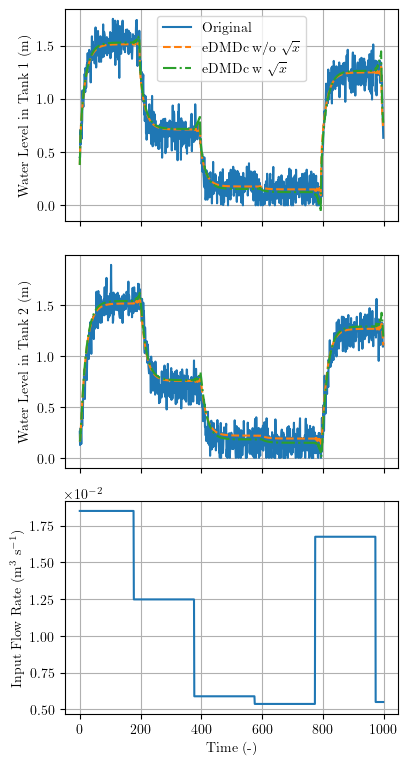

In [41]:
# [donotremove]
fig = plot_results(
    U_t[:part],
    Y_t[:part],
    *[Y_pred[:part] for Y_pred in Y_tests_pred.values()],
    labels=["Original", *list(Y_tests_pred.keys())],
)
fig.savefig(f"{results_path}dmdc_multipred-p{p}-q{q}-hm{hm}-hl{hl}.pdf")

In [37]:
for name, Y_pred in Y_tests_pred.items():
    np.save(f"results/test_pred_{normalize_string(name)}.npy", Y_pred)
for name, model in models.items():
    np.save(f"results/eig_{normalize_string(name)}.npy", model.eig[0])
    np.save(f"results/amplitudes_{normalize_string(name)}.npy", model.xi)

In [38]:
# [donotremove]
def controllability_test(A, B):
    """
    Test the controllability of a system given state-space matrices A and B.

    Parameters:
    A (ndarray): State matrix of size (n, n)
    B (ndarray): Input matrix of size (n, m)

    Returns:
    bool: True if the system is controllable, False otherwise.
    """
    n = A.shape[0]  # Number of states
    controllability_matrix = B

    # Compute [B, AB, A^2B, ..., A^(n-1)B]
    for i in range(1, n):
        controllability_matrix = np.hstack((
            controllability_matrix,
            np.linalg.matrix_power(A, i) @ B,
        ))

    # Check rank of the controllability matrix
    rank = np.linalg.matrix_rank(controllability_matrix)
    return rank == n


A = model.A
B = model.B

is_controllable = controllability_test(A, B)
print(f"System is controllable: {is_controllable}")


def analyze_controllability(A, B):
    n = A.shape[0]
    controllability_matrix = B
    for i in range(1, n):
        controllability_matrix = np.hstack((
            controllability_matrix,
            np.linalg.matrix_power(A, i) @ B,
        ))

    rank = np.linalg.matrix_rank(controllability_matrix)
    return controllability_matrix, rank


C_matrix, rank = analyze_controllability(A, B)
print("Controllability Matrix:")
print(C_matrix)
print(f"Rank: {rank}/{A.shape[0]}")

System is controllable: True
Controllability Matrix:
[[ 7.07734591e-02  2.03885818e+01  3.52254495e+01  1.81636675e+00
  -5.02205728e+00  2.10922467e+01  3.54316443e+01  1.82659330e+00
  -8.07538945e-01  3.41696405e+00  3.44170811e+01  1.79356981e+00
   2.28448498e+00 -1.14790710e+01  3.35707261e+01  1.76622059e+00
   1.29442348e+00 -8.32235826e+00  3.38732638e+01  1.77901427e+00
  -8.75221900e-01  3.19790474e+00  3.46904824e+01  1.80930428e+00
  -7.79627572e-01  5.00686227e+00  3.48695994e+01  1.81697513e+00
  -4.50425610e-02 -3.12963700e+00  3.44103918e+01  1.80209262e+00
   1.64177353e+00 -7.25206606e+00  3.41838570e+01  1.79495309e+00
   1.34792118e-01 -3.20143701e+00  3.44928514e+01  1.80672032e+00
  -4.80092188e-01  1.50829918e+00  3.48151853e+01  1.81846586e+00
  -2.78864128e-02 -1.56797630e+00  3.46247213e+01  1.81177544e+00
   1.48680248e+00 -6.08459962e+00  3.43268514e+01  1.80109568e+00
   1.82789988e-01 -4.32666870e+00  3.44312734e+01  1.80438516e+00
  -2.65419571e-01  1.37